Debido a que el trabajo de los mineros es considerado extremadamente insalubre la empresa, por regulación estatal, tiene que dar 60 días de licencia psicológica por año. Se busca entender qué es lo que produce que los empleados se tomen días por problemas psicológicos. Consultando con psicólogos, les indicaron que el problema se podía originar por los viajes largos y el exceso de tiempo ocioso, propusieron que un indicador podría ser la madurez mental, reflejado en la edad de los mineros. Además uno de los psicólogos propuso medir cuánto leen los mineros.
 
La empresa recabó datos de los últimos años de algunos de sus mejores empleados. Se les mostró una hoja de un largo estandarizado y se le pidió a cada minero que estime cuántas hojas leía al día. Se armó un dataset con la cantidad de días que se pidieron de licencia en los últimos 3 años, su edad actual y la cantidad de hojas que leen por día.

Con los datos recolectados R5 tratar de predecir la cantidad de días de licencia psicológica que se tomaría un empleado en el próximo año.



In [950]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import Image

In [960]:
df = pd.read_csv('R5.csv')

In [163]:
df.describe()

,pages_per_day_samples,age_samples,days_in_yrs_samples
count,150.000000,150.000000,150.000000
mean,52.200000,36.540000,66.280000
std,39.393387,7.485673,49.157755
min,0.000000,21.000000,0.000000
25%,27.000000,31.000000,29.250000
50%,43.000000,36.000000,52.000000
75%,62.000000,41.000000,87.000000
max,250.000000,60.000000,180.000000


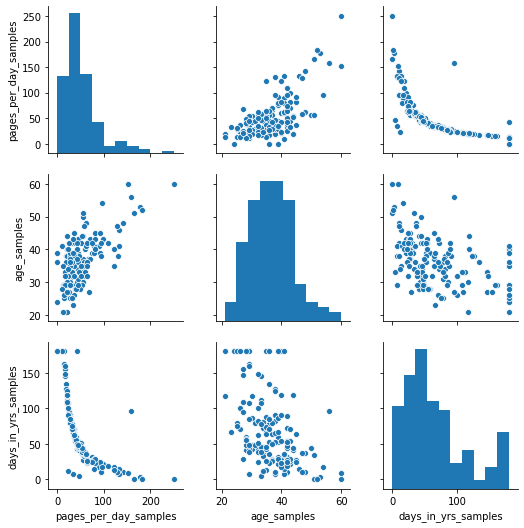


- observamos outliers


In [165]:
sns.pairplot(df)
plt.show()
print()
print("- observamos outliers")

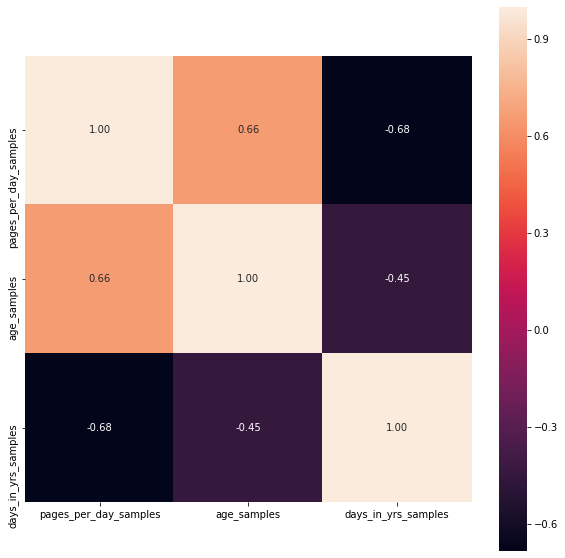

In [166]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f')
plt.show()

In [140]:
def get_column(A, j): 
    return A.iloc[:,j]

def boxplot_list(df):
    
    df = df.copy().dropna()

    _, num_columns = df.shape
    fig, ax = plt.subplots(1, num_columns, figsize = (4 * num_columns, 4)) 
    red_square = dict(markerfacecolor='r', marker='s')
    columns = df.columns.values
    
    for i in range(num_columns):        
        i_column = get_column(df, i)

        ax[i].boxplot(x=i_column, vert=False, flierprops=red_square)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)
        ax[i].set_xlabel(columns[i], fontsize=14)
        
    plt.show()

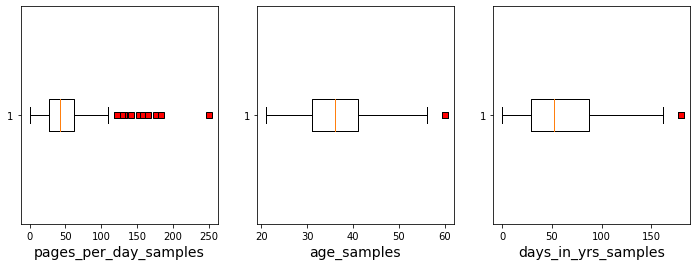

In [218]:
boxplot_list(df)

## Remuevo outliers

In [972]:
# ATENCION !!!
# BUSCAR OUTLIERS USANDO Z SCORE SOLO SIRVE SI LA DISTRIB ES NORMAL !!!
# ENTONCES ESTO QUE HICE ESTA MAL, DEBERIA HACER ALGO COMO:
#
# q = df['pages_per_day_samples'].quantile(0.95)
# df_ = df[df['pages_per_day_samples'] < q]
#
# CON ESTO REMUEVO EL 5% DE ARRIBA DE LA DISTRIBUCION
#

# encuentro outliers con una desviacion estandar normal > 3
threshold = 3
z = np.abs(stats.zscore(df.dropna()))
outliers = np.where(z > threshold)
#outliers[0] corresponde al nro de row
#outliers[1] corresponde al nro de col
print(outliers[0])

#count = 0
#for i in outliers[0]:
#    print(df[df.index == i])
#    column_index = outliers[1][count]
#    print("columna:", df.columns[column_index])
#    count = count + 1
#    print("===============")

#removing duplicated indexes
outliers_list = outliers[0]
outliers_list = list(dict.fromkeys(outliers_list))

for outlier_index in outliers_list:
    df.drop(outlier_index, inplace=True)
    df.reset_index(drop=True, inplace=True)

[]


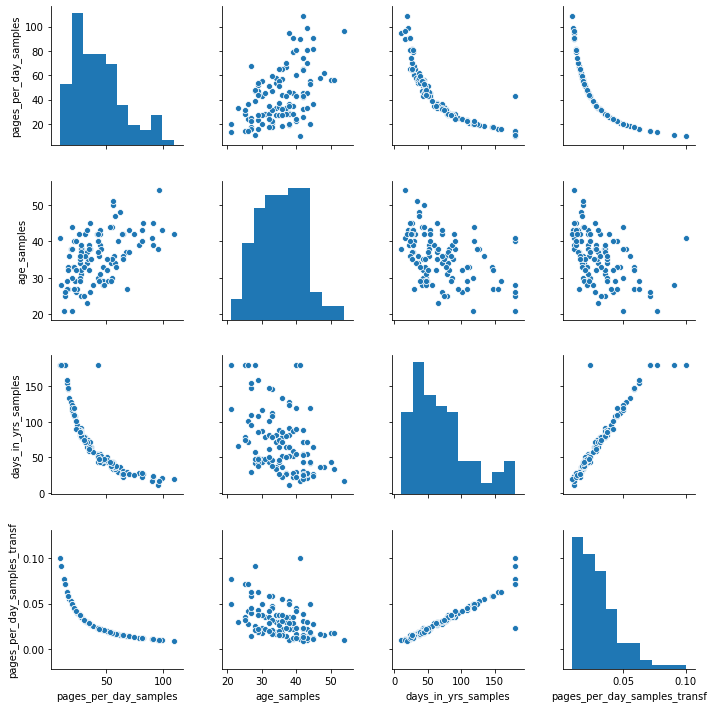


- comparando con el pairplot inicial se puede observar una limpieza de outliers
  aunque algunos permaneces, los elimino a mano


In [991]:
sns.pairplot(df)
plt.show()
print()
print("- comparando con el pairplot inicial se puede observar una limpieza de outliers")
print("  aunque algunos permanecen, los elimino a mano")

In [998]:
#identifico outliers a mano
df[(df['days_in_yrs_samples'] > 175) & (df['pages_per_day_samples'] < 50)]

,pages_per_day_samples,age_samples,days_in_yrs_samples,pages_per_day_samples_transf


In [997]:
#elimino outliers a mano
df.drop([9,45,72,79,84,88], inplace=True)

## feature engineering

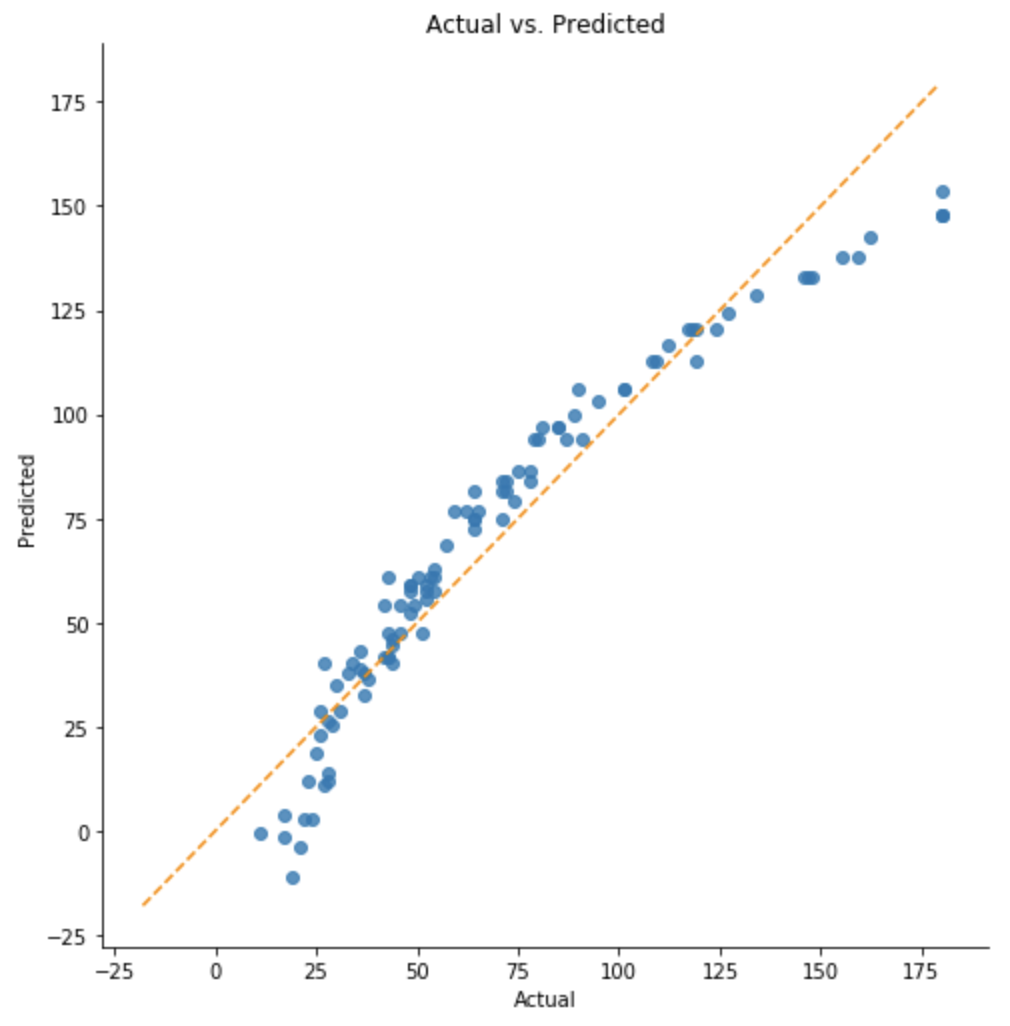

In [952]:
# Probamos crear la feature df['pages_per_day_samples_x_age_samples'] = df.pages_per_day_samples * df.age_samples
# con la intencion de averiguar si existe sinergia entre estas, obtener un mejor coef de correlacion y
# que nos sea util al calcular la regresion lineal, pero la feature resultante no tenia tanto mas coef de corr
# que las feature que la formaron. Ademas producia un grado de multicolinearidad alto en el dataset y no 
# aporto en la busqueda de mejores metricas al entrenar el modelo.

# Probamos con la transformacion df['log_pages_per_day_samples'] = np.log(df.pages_per_day_samples)
# porque days_in_yrs_samples parece tener una relacion logaritmica, pero no se ajusta del todo bien.
# De hecho si entrenamos la linear regression solo con log_pages_per_day_samples y chequeamos la 
# 1er linear_assumption podemos notar que los residuals no se distribuyen simetricamente (se adjunta img)
#
Image("picture-01.png", width=300)

In [986]:
# Averiguamos que la relacion entre 'pages_per_day_samples' y 'days_in_yrs_samples' tienen la forma y = 1/Ax + B

df['pages_per_day_samples_transf'] = 1 / (df.pages_per_day_samples)
df = df[(df != 0).all(1)] #removing -inf values ( X == 0 )

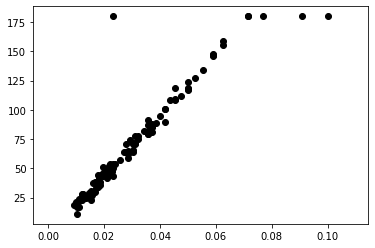

- Observamos que pudimos transformar pages_per_day_samples en una funcion lineal


In [987]:
plt.scatter(df.pages_per_day_samples_transf, df.days_in_yrs_samples,  color='black')
plt.show()
print("- Observamos que pudimos transformar pages_per_day_samples en una funcion lineal")

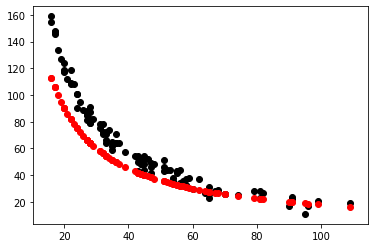


#Ahora sabemos que la funcion tiene la forma de y = 1/Ax + B
#funcion_days_in_yrs_samples(pages_per_day_samples) = 1800/pages_per_day_samples"
#entonces si t = 1 / pages_per_day_samples me queda que:
#funcion_days_in_yrs_samples(t) = 1800 * t



In [1059]:
fc = 1800/(df.pages_per_day_samples) + 0

plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.show()

print("""
#Ahora sabemos que la funcion tiene la forma de y = 1/Ax + B
#funcion_days_in_yrs_samples(pages_per_day_samples) = 1800/pages_per_day_samples"
#entonces si t = 1 / pages_per_day_samples me queda que:
#funcion_days_in_yrs_samples(t) = 1800 * t
""")

## Fit model 

In [989]:
def print_model_statistics(regr, y_test, y_pred):

    # The coefficients
    print('Coefficients: ', regr.coef_)

    # The intercept_ 
    print('Intercept (Y axis when X = 0): ', regr.intercept_)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: %.2f' % r2)
    
    # Adjusted r2
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
    print('Adjusted r2: %.2f' % adjusted_r2)
    
    #explained_variance_score
    print('explained_variance_score: %.2f' % explained_variance_score(y_test, y_pred))

## LinearRegression 

In [1071]:
X = df[[
#    'pages_per_day_samples',
#   'age_samples',
    'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

print("")
print("- Se puede observer que agregar la age_samples no mejora las metricas")

Coefficients:  [2602.15480723]
Intercept (Y axis when X = 0):  -8.938021299405378
Mean squared error: 11.78
Coefficient of determination: 0.99
Adjusted r2: 0.98
explained_variance_score: 0.99

- Se puede observer que agregar la age_samples no mejora las metricas


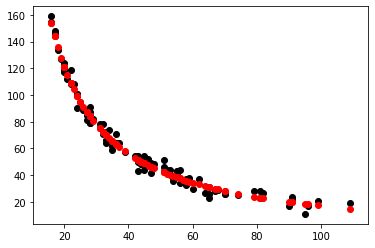

In [1075]:
fc = 2602.15480723/(df.pages_per_day_samples) + -8.938021299405378
plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.show()

In [1028]:
# Entreno modelo lineal con 2 features y grafico el plano resultante de la reg lineal. Esto es solo por deporte, 
# ya sabemos que age_samples aporta poco y nada a la regresion.
#

X = df[['age_samples',
        'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

Coefficients:  [2.56139409e-02 2.60759965e+03]
Intercept (Y axis when X = 0):  -10.016496711812579
Mean squared error: 11.33
Coefficient of determination: 0.99
Adjusted r2: 0.98
explained_variance_score: 0.99


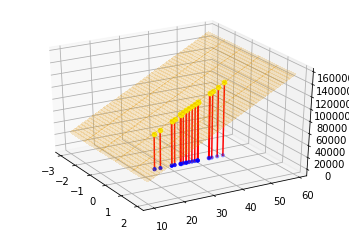

In [1029]:
from mpl_toolkits.mplot3d import Axes3D
import math

ax = plt.figure().gca(projection='3d')
ax.scatter(X_test['pages_per_day_samples_transf'], X_test['age_samples'], y_test.values, color="blue", s=10)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

count = 0
for i in range(len(X_test)):
    xs = X_test['pages_per_day_samples_transf'].values[count]
    ys = X_test['age_samples'].values[count]
    zs = y_test.to_numpy()[count]#lo convierto a array asi no lo accede por indice !!
    pred_z = regr.predict([[xs, ys]])
    
    ax.plot([xs, xs], [ys, ys], [zs, pred_z], color="red")
    ax.scatter(xs, ys, pred_z, marker='o', color="yellow")
    
    count = count + 1

#plano
xx, yy = np.meshgrid(range(-3,3), range(10,60))
model_z_vals = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        model_z_vals[i, j] = regr.predict([[xx[i][j], yy[i][j]]])

ax.plot_surface(xx, yy, model_z_vals, alpha=0.2, color="orange", antialiased=False)

ax.view_init(30, -30)
plt.draw()
plt.pause(.001)

## MLPRegressor 

In [1034]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

X = df[['pages_per_day_samples_transf',
        'age_samples'
       ]]
y = df.days_in_yrs_samples

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_nn = MLPRegressor(max_iter=10000, activation='logistic', learning_rate='adaptive')
model_nn.fit(X_train,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [1035]:
y_pred = model_nn.predict(X_test)

In [1036]:
print(mean_squared_error(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))

13.175435383914907
0.9840725075793365


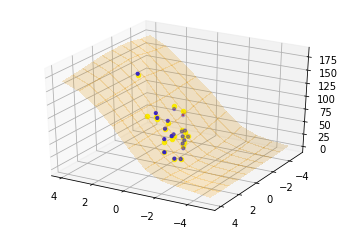

In [1045]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().gca(projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test.values, color="blue", s=10)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

count = 0
for item in X_test:
    item[0]
    xs = item[0]
    ys = item[1]
    zs = y_test.to_numpy()[count]#lo convierto a array asi no lo accede por indice !!
    pred_z = model_nn.predict([[xs, ys]])
    
    ax.plot([xs, xs], [ys, ys], [zs, pred_z], color="red")
    ax.scatter(xs, ys, pred_z, marker='o', color="yellow")
    
    count = count + 1
    
xx, yy = np.meshgrid(range(-5,5), range(-5,5))
model_z_vals = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        model_z_vals[i, j] = model_nn.predict([[xx[i][j], yy[i][j]]])

ax.plot_surface(xx, yy, model_z_vals, alpha=0.2, color="orange", antialiased=False)    

ax.view_init(30, 120)
plt.draw()
plt.pause(.001)

## xgboost 

In [1050]:
param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
#        'gamma': [0, 0.25, 0.5, 1.0],
#        'n_estimators': [100]
}

In [1051]:
clf = xgb.XGBClassifier()
#cv=3 uso la misma que en xgb.cv mas arriba
rs_clf = RandomizedSearchCV(clf, param_grid,      
                      verbose=2, cv=3,  
                      scoring='neg_mean_squared_error', 
                     )

In [1054]:
#'log_pages_per_day_samples', corresponde a np.log(df.'pages_per_day_samples')
#'log_pages_per_day_samples_x_age_samples' corresponde a log_pages_per_day_samples * age_samples
X = df[['pages_per_day_samples',
        'age_samples',
        #'log_pages_per_day_samples',
        #'log_pages_per_day_samples_x_age_samples'
       ]]
y = df.days_in_yrs_samples

print("Randomized search..")
search_time_start = time.time()
#le paso X, y en vez de el x_train, y_train ( que es un % del total ) porque estoy usando cross validation, 
#si no usara CV deberia tener cuidado y validar si le paso x_train, y_train , xq se podria dar el caso de que 
# como hace el entrenamiento con la totalidad de los datos, luego el x_test, y_test van a dar muy bien y no es el caso.
rs_clf.fit(X, y)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=5.0, max_depth=20, learning_rate=0, colsample_bytree=0.4 
[CV]  silent=False, reg_alpha=5.0, max_d

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.3s finished


In [1058]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))
    
print("\n- Las metricas obtenidas con XGBoost son mucho peores que las obtenidas con la reg lineal o la NN")

Best score: -233.80476190476188
Best params: 
colsample_bytree: 1.0
learning_rate: 0.2
max_depth: 20
reg_alpha: 1.0
silent: False

- Las metricas obtenidas con XGBoost son mucho peores que las obtenidas con la reg lineal o la NN
